In [1]:
from grizli import multifit
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
import astropy.io.fits as pyfits
import warnings
warnings.filterwarnings('ignore')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
myfontsize=22
plt.rcParams.update({'font.size': myfontsize})
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,ScalarFormatter, NullFormatter,MaxNLocator, NullLocator,LogLocator
import os
os.environ['PYSYN_CDBS'] ='/Users/kawinwanichakij/pysynphot/trds/'
import pysynphot as S

Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git


In [3]:
#mb=multifit.MultiBeam('/Users/kawinwanichakij/JWST/NIRISS/OutThere/sex-07/sex-07_01390.beams.fits')

In [7]:
for i in range(len(mb.beams)):
    print(i,mb.beams[i].grism.pupil)

0 F150W
1 F115W
2 F115W
3 F200W
4 F200W
5 F115W
6 F115W
7 F115W
8 F115W
9 F150W
10 F200W
11 F115W
12 F200W
13 F115W
14 F115W
15 F150W
16 F115W
17 F115W
18 F150W
19 F115W
20 F115W
21 F115W
22 F115W
23 F115W
24 F115W
25 F150W
26 F115W
27 F115W
28 F150W
29 F200W
30 F115W
31 F200W
32 F115W
33 F115W
34 F150W
35 F115W
36 F115W
37 F150W
38 F115W
39 F200W
40 F200W
41 F115W
42 F150W
43 F115W
44 F200W


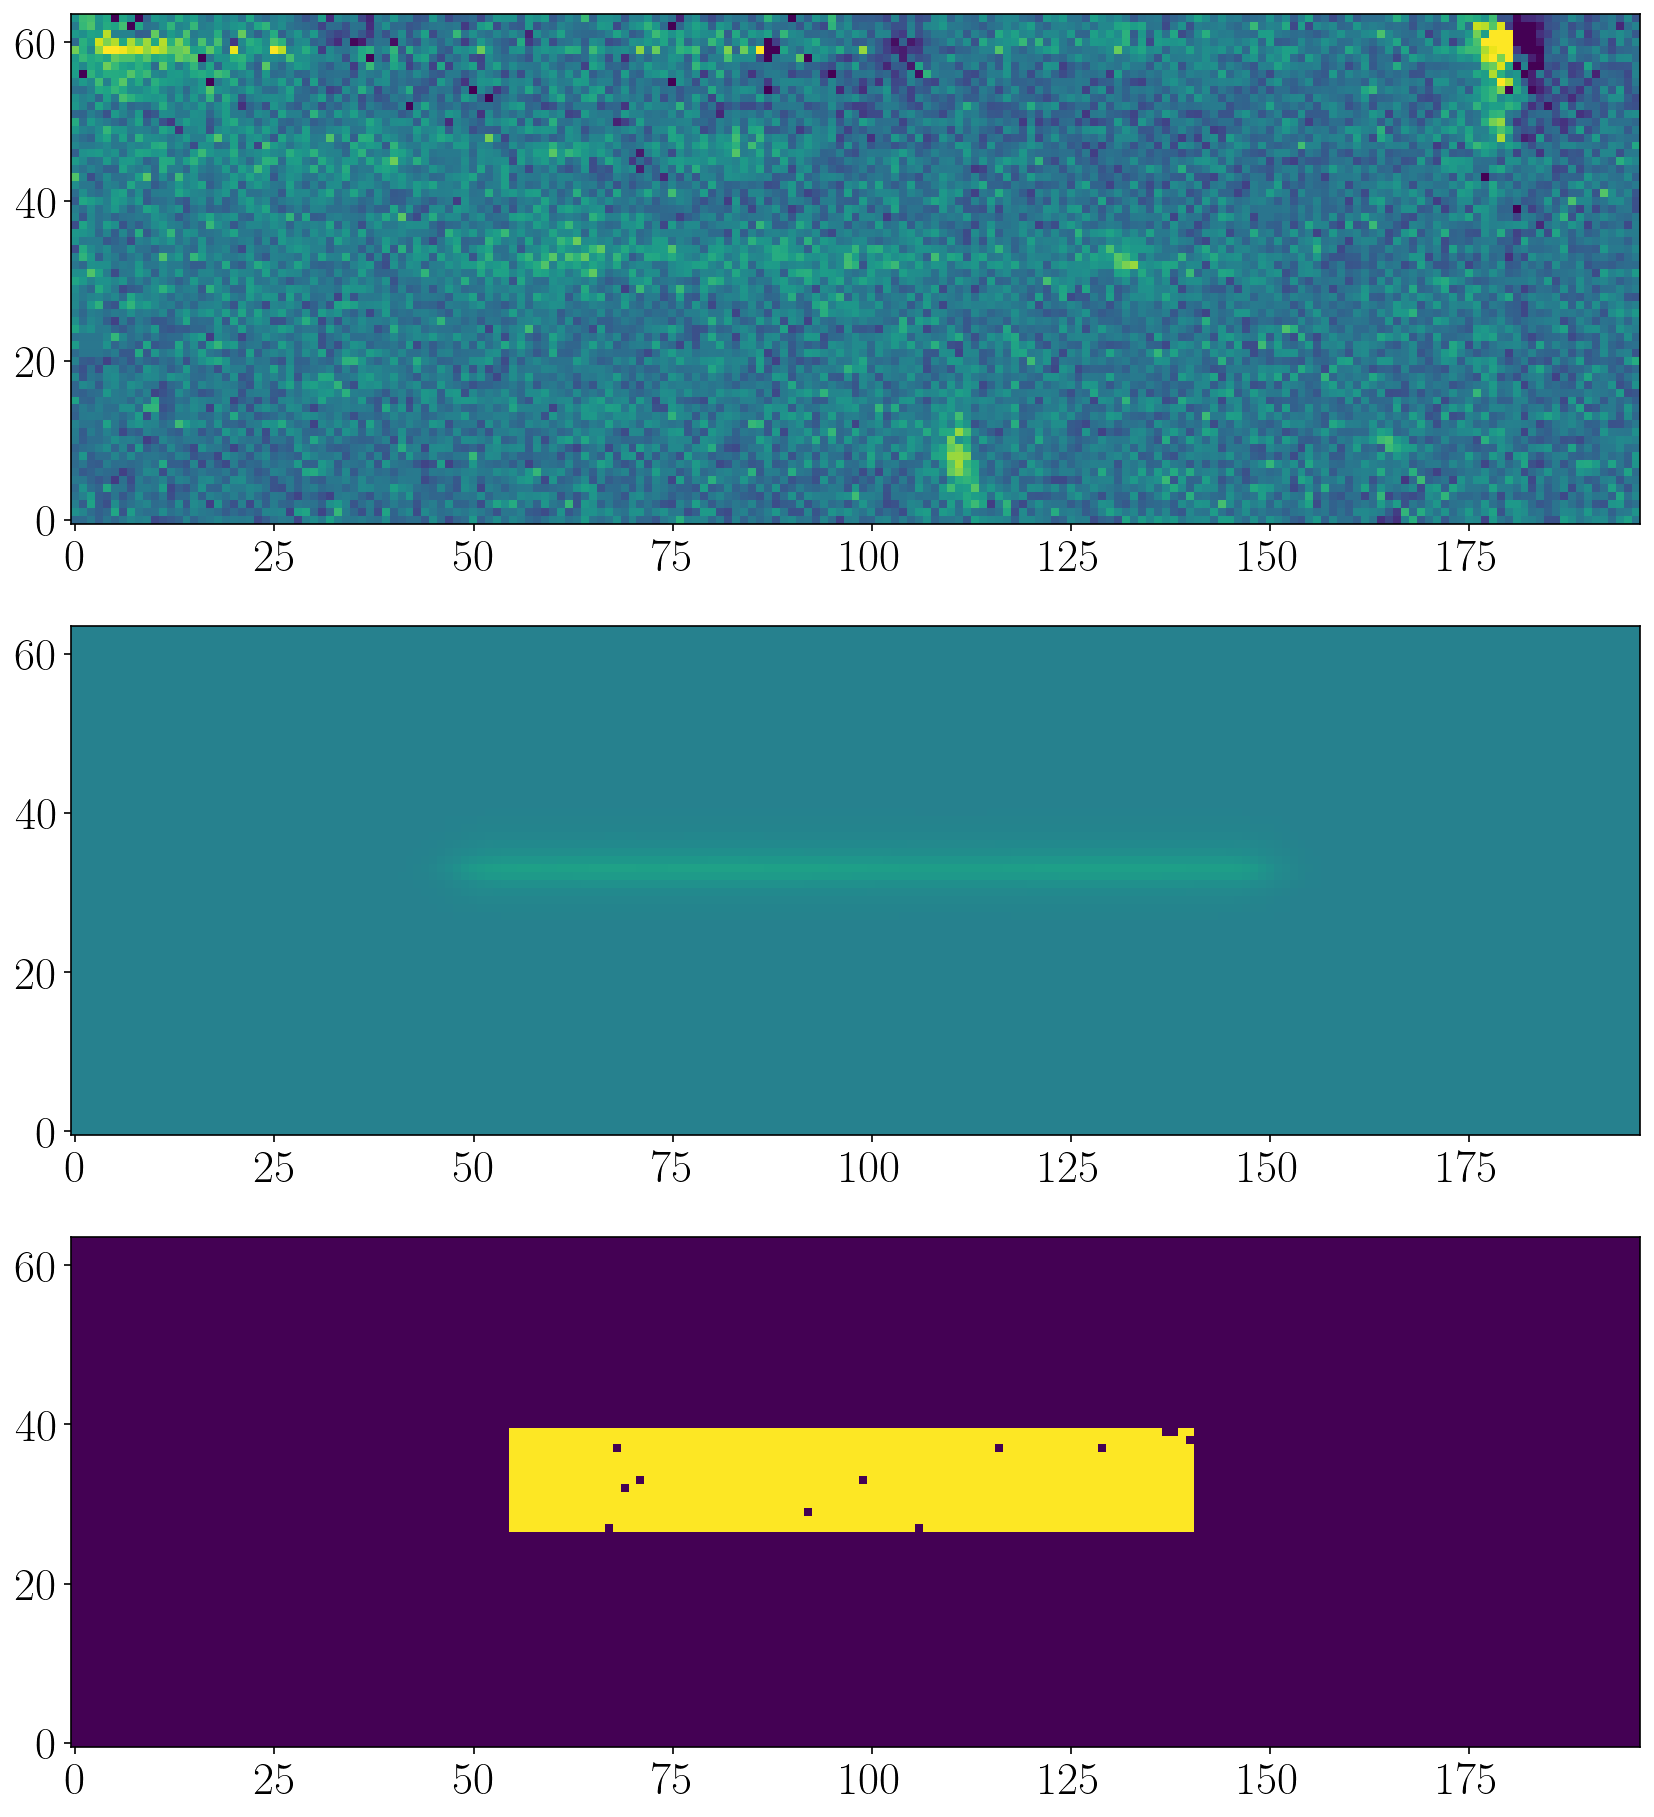

In [18]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()


beam_ind= 4
fig,axs= plt.subplots(3,1,figsize=(15,15),dpi=150)
sci_grism = mb.beams[beam_ind].scif.reshape(mb.beams[beam_ind].sh)
model_grism = mb.beams[beam_ind].model
fit_mask = mb.beams[beam_ind].fit_mask.reshape(mb.beams[beam_ind].sh)
vmin, vmax = zscale.get_limits(sci_grism)
axs[0].imshow(sci_grism,origin='lower',vmin=vmin,vmax=vmax)
axs[1].imshow(model_grism,origin='lower',vmin=vmin,vmax=vmax)
axs[2].imshow(fit_mask,origin='lower')


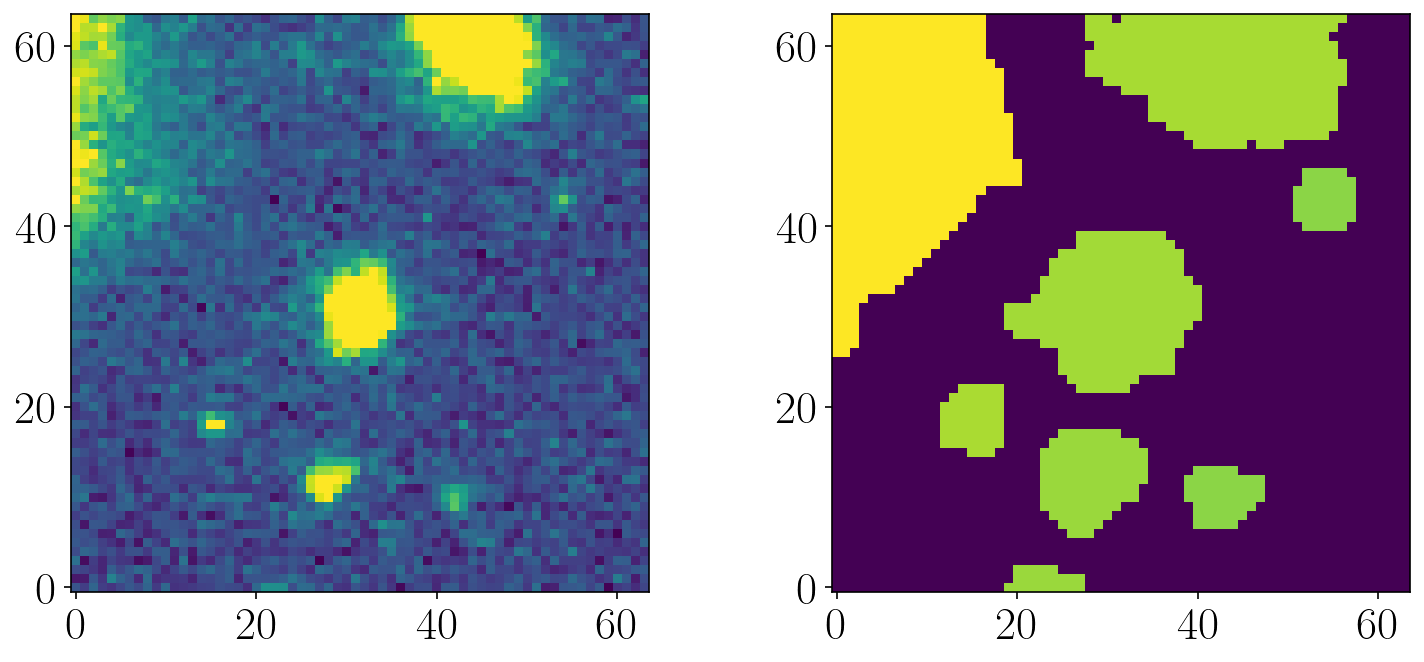

In [35]:
zscale = ZScaleInterval()
fig,axs= plt.subplots(1,2,figsize=(12,5),dpi=150)

sci_ref= mb.beams[beam_ind].direct.data['REF']
seg = mb.beams[beam_ind].beam.seg
vmin, vmax = zscale.get_limits(sci_ref)
axs[0].imshow(sci_ref,origin='lower',vmin=vmin,vmax=vmax)
axs[1].imshow(seg,origin='lower')

In [37]:
np.sum(sci_ref[seg==1390])

64.993004

In [43]:
# direct image flux
# pivot wavelength mb.beams[beam_ind].direct.photplam
mb.beams[beam_ind].beam.total_flux/1.e-19

0.4892616288181744

0.016430166074602834 0.49136777282940225
0.08586117743512263 0.4892616288181744
0.03274512629046084 0.49109389849846474
0.03567926654319476 0.48929794721694436
0.005168109176736976 0.49138748299243573
0.049253515476390446 0.49109751741364466
0.059285385793757715 0.4913469640671177
-0.018278248276049888 0.48928308381531255
0.0019437742774829564 0.4911020087458769


Text(0, 0.5, '$f_\\lambda\\,/\\,10^{-19}\\,\\mathrm{cgs}$')

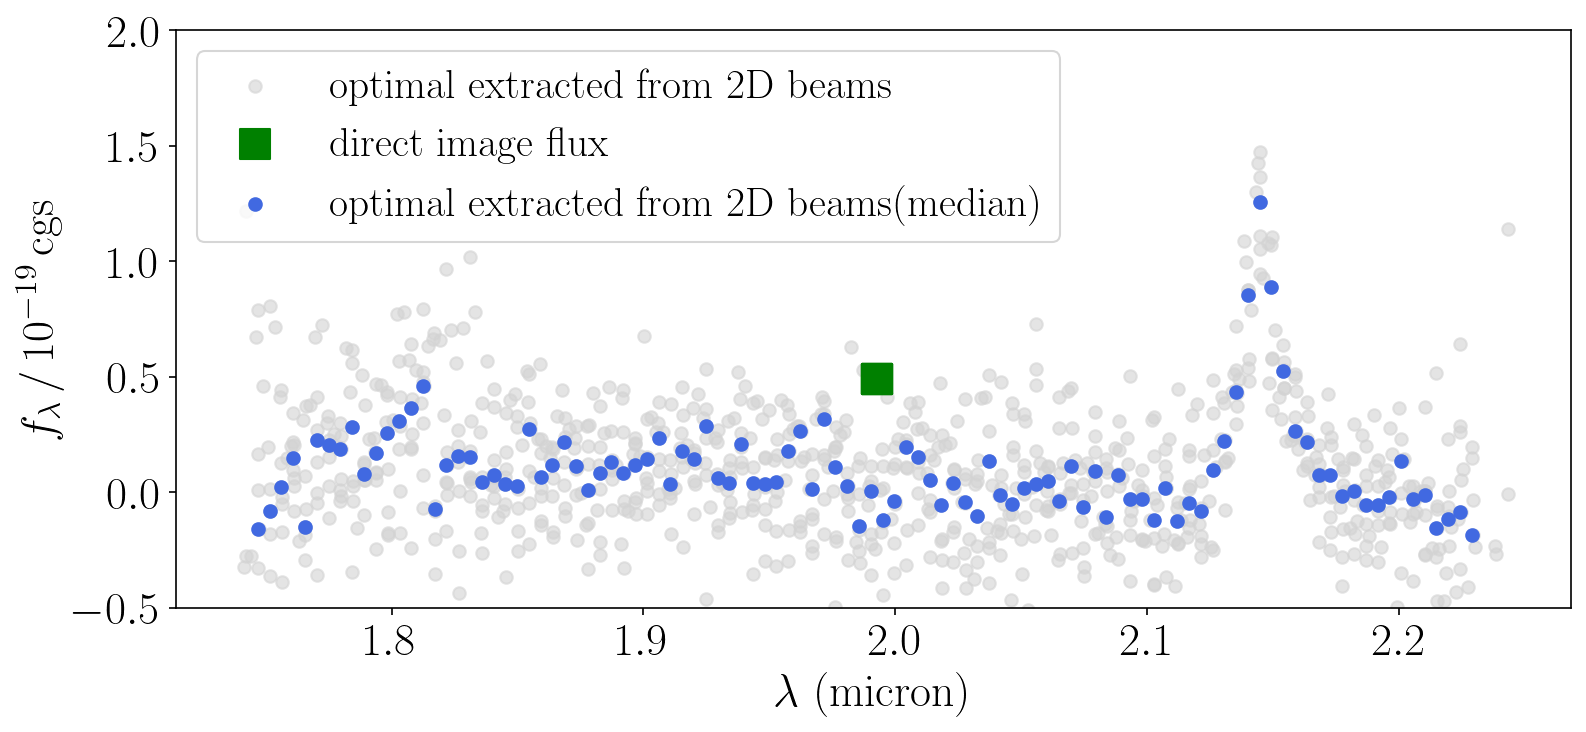

In [13]:
fcontam = 0.1
fscl = 1./1.e-19 
fig,ax= plt.subplots(figsize=(12,5),dpi=150)
k=0
_extracted_beam_flux = []
_extracted_beam_wave = []
for beam_ind in range(len(mb.beams)):
    if mb.beams[beam_ind].grism.pupil == 'F200W':
        if k ==0:
            label_beam= 'optimal extracted from 2D beams'
            label_refflux = 'direct image flux'
        if k >0:
            label_beam=None
            label_refflux=None
        #print(mb.beams[beam_ind].beam.total_flux/1.e-19)
        clean =  mb.beams[beam_ind].grism['SCI']-mb.beams[beam_ind].contam
        ivar = mb.beams[beam_ind].ivar

        weight = np.exp(-(fcontam*np.abs(mb.beams[beam_ind].contam)*np.sqrt(ivar)))
        wave, flux, err = mb.beams[beam_ind].beam.optimal_extract(clean,ivar=ivar,weight=weight)
        flat = mb.beams[beam_ind].flat_flam.reshape(mb.beams[beam_ind].beam.sh_beam)
        wave, fflux, ferr = mb.beams[beam_ind].beam.optimal_extract(flat, ivar=ivar,weight=weight)
        ok =  mb.beams[beam_ind].beam.sensitivity > 0.1* mb.beams[beam_ind].beam.sensitivity.max()
        flux = (flux*fscl/fflux)[ok]* mb.beams[beam_ind].beam.scale
        ax.scatter(wave[ok]/1.e4, flux,label=label_beam,color='lightgrey',alpha=0.6)
        ax.scatter(mb.beams[beam_ind].direct.photplam/1.e+4,mb.beams[beam_ind].beam.total_flux/1.e-19 ,marker='s',s=200,
                   label=label_refflux,color='green')
        #print(len(flux),mb.beams[beam_ind].beam.scale)
        flux_integrated = np.trapz(flux, wave[ok]/1.e4)
        print(flux_integrated,mb.beams[beam_ind].beam.total_flux/1.e-19)
        _extracted_beam_flux.append(flux)
        _extracted_beam_wave.append(wave[ok]/1.e4)
        k=k+1
extracted_beam_flux = np.zeros( (len(_extracted_beam_flux),len(_extracted_beam_flux[0])))
extracted_beam_wave = np.zeros( (len(_extracted_beam_wave),len(_extracted_beam_wave[0])))
for i in range(len(_extracted_beam_flux)):
    extracted_beam_flux[i,:] =_extracted_beam_flux[i]
    extracted_beam_wave[i,:] =_extracted_beam_wave[i]
ax.set_ylim(-0.5,2)
ax.scatter( np.median(extracted_beam_wave,axis=0), np.median(extracted_beam_flux,axis=0),color='royalblue',marker='o',
          label='optimal extracted from 2D beams(median)')
ax.legend(fontsize=20)
ax.set_xlabel(r'$\lambda$ (micron)')
ax.set_ylabel( r'$f_\lambda\,/\,10^{-19}\,\mathrm{cgs}$')

In [4]:
wavelength=np.median(extracted_beam_wave,axis=0)
flux =  np.median(extracted_beam_flux,axis=0)

# Compute delta_lambda (bin width)
delta_lambda = np.diff(wavelength)

# For simplicity, assume last bin width same as second last
delta_lambda = np.append(delta_lambda, delta_lambda[-1])

# Compute total flux by summing flux density * bin width
total_flux = np.sum(flux * delta_lambda)

print(f"Total flux = {total_flux:.3e} erg/s/cm²")

Total flux = 2.264e-02 erg/s/cm²


In [5]:
beam_ind=4
mb.beams[beam_ind].beam.total_flux/1.e-19

0.4892616288181744

In [10]:
np.shape(mb.beams[beam_ind].beam.lam_beam)

(133,)

In [22]:
full_hdul=pyfits.open('/Users/kawinwanichakij/JWST/NIRISS/OutThere/sex-07/sex-07_01390.full.fits')

In [23]:
full_hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                31280 / length of dimension 1                          
NAXIS2  =                  641 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
TTYPE1  = 'zgrid   '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'chi2    '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'coeffs  '        

In [24]:
full_hdul[1].header['PHOTF002']/1e-19

0.524845964111334

In [4]:
spec1d_hdul=pyfits.open('/Users/kawinwanichakij/JWST/NIRISS/OutThere/sex-07/sex-07_01390.1D.fits')

In [13]:
from astropy.table import Table
spec1d = Table(spec1d_hdul['F200W'].data)
pscale= spec1d['pscale']
#print(pscale)
flux =(spec1d['flux']/spec1d['flat'])/(1.e-19 )/pscale # 1D spectra
err = (spec1d['err']/spec1d['flat'])/(1.e-19 ) /pscale
cont=(spec1d['cont']/spec1d['flat'])/(1.e-19 ) # continuum model
line = (spec1d['line']/spec1d['flat'])/(1.e-19 )
contam= (spec1d['contam']/spec1d['flat'])/(1.e-19 )/pscale
wave = spec1d['wave']#/(1e+4)

selgood= (np.where(np.isfinite(flux )))[0]

In [14]:
this_flux =(spec1d['flux']/spec1d['flat'])/pscale 

spec = S.ArraySpectrum(wave=spec1d['wave'][selgood], 
                       flux=this_flux[selgood], fluxunits='flam',waveunits='angstrom')

Warning, 2 of 120 bins contained negative fluxes; they have been set to zero.


In [15]:
from pysynphot.spectrum import ArraySpectralElement

In [17]:

bandpass_data = np.loadtxt('JWST_NIRISS.F200W.dat')
bp_wave = bandpass_data[:,0]  # Angstroms
bp_thru = bandpass_data[:,1]  # throughput

# Create TabularSpectralElement for bandpass
bandpass = ArraySpectralElement(bp_wave, bp_thru, waveunits='angstrom')


# Compute the observed flux
obs = S.Observation(spec, bandpass, force='taper')

# Flux density in erg/s/cm²/Å
f_lambda = obs.effstim('flam')

(UnnamedArrayBandpass) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


In [25]:
f_total = full_hdul[1].header['PHOTF002']/1e-19
f_1dspec = f_lambda/(1e-19)
diff = -2.5*np.log10(f_total/f_1dspec)

In [26]:
diff

0.18247450248845498

In [28]:
spec1d_hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ID      =                 1390 / Object ID                                      
RA      =    150.0909527874153 / Right Ascension                                
DEC     =    2.412353758036078 / Declination                                    
TARGET  = 'sex-07  '           / Target Name                                    
MW_EBV  =                  0.0 / Galactic extinction E(B-V)                     
N_G102  =                    0 / Number of exposures                            
T_G102  =                    0 / Total exposure time                            
PA_G102 =                    0 / Number of PAs                                  
N_G141  =                   